In [6]:
from utility import *
import warnings
warnings.filterwarnings('ignore') 

the feature space becomes sparse as we increased the dimensionality of small datasets. This makes the classifeir easily overfit and the solution is simply to reduce the dimensionality.

In [2]:
from featurization import *
import pandas as pd 
import numpy as np


train = pd.read_csv('Joel\\datasets\\sds\\train_04.csv')
test = pd.read_csv('Joel\\datasets\\sds\\test_04.csv')
train_features, test_features, feature_names = featurize(train, test, 'tfidf_glove')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Emoji re....
Num dots....
Punctuation....
Sentiment Scores....
Text Features....
Glove.....


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

DONE!


## Feature Selection
### SelectKBest

#### Openness

In [3]:
test[test.off_bin == 0].shape[0]

13

In [7]:
y_train = np.where(train.off_bin.values == 1, 1, 0)
y_test = np.where(test.off_bin.values == 1, 1, 0)

In [5]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k = 80)
train_features_selected = selector.fit_transform(train_features, y_train)
test_features_selected = selector.transform(test_features)
run_log_reg(train_features_selected, test_features_selected, y_train, y_test)


F1: 0.588 | Pr: 0.458 | Re: 1.000 | AUC: 0.483 | Accuracy: 0.417 



SGDClassifier(loss='log', n_jobs=-1)

In [6]:
# Lets run a for loop to select the value of K that optimizes F1

f1_scores = []

for k in tqdm_notebook(range(1, train_features.shape[1])):
    selector = SelectKBest(k = k)
    train_features_selected = selector.fit_transform(train_features, y_train)
    test_features_selected = selector.transform(test_features)
    f1_scores.append(run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2, return_f1 = True, verbose = 0))
f1_scores = np.array(f1_scores)

  0%|          | 0/308 [00:00<?, ?it/s]

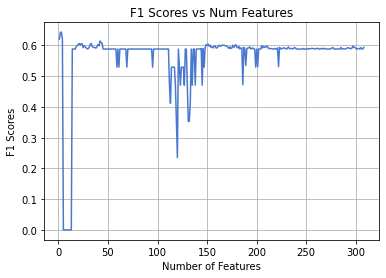

In [7]:
# Now let's plot the F1 scores:
import matplotlib.pyplot as plt

%matplotlib inline

x = list(range(1, train_features.shape[1]))
plt.plot(x, f1_scores)
plt.xlabel('Number of Features')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Num Features')
plt.grid()
plt.show()


In [8]:
print(np.argmax(f1_scores) + 1)

2


In [9]:
selector = SelectKBest(k = 2)
train_features_selected = selector.fit_transform(train_features, y_train)
test_features_selected = selector.transform(test_features)
run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)

F1: 0.643 | Pr: 0.556 | Re: 0.909 | AUC: 0.550 | Accuracy: 0.583 



SGDClassifier(alpha=0.01, loss='log', n_jobs=-1)

In [10]:
# we can use get_support() to find out exactly which features were selected
np.array(feature_names)[selector.get_support()]

array(['num_dots', 'fasttext_26'], dtype='<U19')

A disadvantage of SelectKBest is that we manually need to select the number of features we want to keep. SelectPercentile does the same thing, except this time we can pass the percentage of features we want to keep.


### SelectPercentgile

In [11]:
from sklearn.feature_selection import SelectPercentile

f1_scores = []

for percentage in tqdm_notebook(range(1, 101)):
    selector = SelectPercentile(percentile = percentage)
    train_features_selected = selector.fit_transform(train_features, y_train)
    test_features_selected = selector.transform(test_features)
    f1_scores.append(run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2, return_f1 = True, verbose = 0))
f1_scores = np.array(f1_scores)


  0%|          | 0/100 [00:00<?, ?it/s]

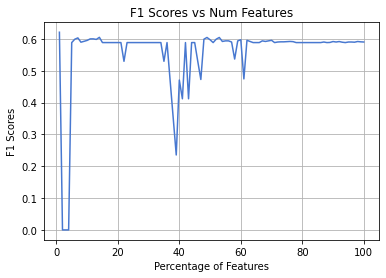

In [12]:
# Now let's plot the F1 scores:
import matplotlib.pyplot as plt

%matplotlib inline

x = list(range(1, 101))
plt.plot(x, f1_scores)
plt.xlabel('Percentage of Features')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Num Features')
plt.grid()
plt.show()



In [13]:
print(np.argmax(f1_scores) + 1)

1


In [14]:
selector = SelectPercentile(percentile = 1)
train_features_selected = selector.fit_transform(train_features, y_train)
test_features_selected = selector.transform(test_features)
run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)

F1: 0.623 | Pr: 0.529 | Re: 0.909 | AUC: 0.585 | Accuracy: 0.546 



SGDClassifier(alpha=0.01, loss='log', n_jobs=-1)

In [15]:
np.array(feature_names)[selector.get_support()]

array(['num_dots', 'fasttext_26', 'fasttext_56', 'fasttext_87'],
      dtype='<U19')

### RFECV (Recursive Featgures Elimination


RFE is a backward feature selection technique that uses an estimator to calculate the feature importance at each stage. The word recursive in the name implies that the technique recursively removes features that are not important for classifiction.

We'll use the CV variant which uses cross-validation inside each loop to determine how many features to remove in each loop. RFECV needs an estimator which has the feature_importances_ attribute so we'll use SGDClassifier with log loss.


In [8]:
# Since we have a hold out Test set that we would like to use - Let's create a `PredefinedSplit`
from sklearn.model_selection import PredefinedSplit

X = sparse.vstack((train_features, test_features))
test_fold = [-1 for _ in range(train_features.shape[0])] + [0 for _ in range(test_features.shape[0])]     # We need to label -1 for the train set and 0 for test set
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

In [17]:
from sklearn.feature_selection import RFECV

log_reg = SGDClassifier(loss = 'log', alpha = 1e-3)

selector = RFECV(log_reg, scoring = 'f1', n_jobs = -1, cv = ps, verbose = 1)
selector.fit(X, y)

Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
Fitting estimator with 298 features.
Fitting estimator with 297 features.
Fitting estimator with 296 features.
Fitting estimator with 295 features.
Fitting estimator with 294 features.
Fitting estimator with 293 features.
Fitting estimator with 292 features.
Fitting estimator with 291 features.
Fitting estimator with 290 features.
Fitting estimator with 289 features.
Fitting estimator with 288 features.
Fitting estimator with 287 features.
Fitting estimator with 286 features.
Fitting estimator with 285 features.
Fitting estimator with 284 features.
Fitting estimator with 283 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=SGDClassifier(alpha=0.001, loss='log'), n_jobs=-1, scoring='f1',
      verbose=1)

In [23]:
# Now lets select the best features and check the performance
train_features_selected = selector.transform(train_features)
test_features_selected = selector.transform(test_features)

run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-1)

F1: 0.783 | Pr: 0.769 | Re: 0.909 | AUC: 0.853 | Accuracy: 0.792 



SGDClassifier(alpha=0.1, loss='log', n_jobs=-1)

In [24]:
# Lets check which features were selected 

print('Number of features selected : {}'.format(selector.n_features_))
np.array(feature_names)[selector.support_]

Number of features selected : 10


array(['length_in_chars', 'fasttext_26', 'fasttext_30', 'fasttext_57',
       'fasttext_69', 'fasttext_148', 'fasttext_231', 'fasttext_234',
       'fasttext_250', 'fasttext_272'], dtype='<U19')

### SFS (Sequential Forward Selection)
Finally, let's try SFS - which does the same thing as RFE instead adds features sequentially. SFS starts with 0 features and adds features 1-by-1 in each loop in a greedy manner. One small difference is that SFS solely uses the feature sets performance on the CV set as a metric for selecting the best features, unlike RFE which used model weights (feature_importances_)

In [9]:
# Note: MLxtend provides the SFS Implementation
from mlxtend.feature_selection import SequentialFeatureSelector

log_reg = SGDClassifier(loss = 'log', alpha = 1e-2)

selector = SequentialFeatureSelector(log_reg, k_features = 'best', floating = True, cv = ps, scoring = 'f1', verbose = 1, n_jobs = -1) # k_features = 'best' returns the best subset of features
selector.fit(X.tocsr(), y)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 309 out of 309 | elapsed:    3.2s finished
Features: 1/309[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 308 out of 308 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/309[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 307 out of 307 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:

SequentialFeatureSelector(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                          estimator=SGDClassifier(alpha=0.01, loss='log'),
                          floating=True, k_features='best', n_jobs=-1,
                          scoring='f1', verbose=1)

In [10]:
# Now lets select the best features and check the performance
train_features_selected = selector.transform(train_features.tocsr())
test_features_selected = selector.transform(test_features.tocsr())

run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)

F1: 0.903 | Pr: 0.937 | Re: 0.973 | AUC: 0.986 | Accuracy: 0.912 



SGDClassifier(alpha=0.01, loss='log', n_jobs=-1)

F1: 0.909 | Pr: 0.917 | Re: 1.000 | AUC: 0.986 | Accuracy: 0.917 



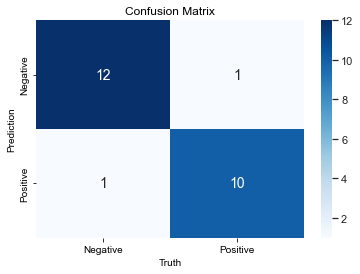

In [11]:
log_reg.fit(train_features_selected, y_train)
y_pred_prob = (log_reg.predict_proba(test_features_selected)[:,1])


print_model_metrics(y_test, y_pred_prob, confusion = True)

In [12]:
print('Num of features selected : {}'.format(len(selector.k_feature_idx_)))
np.array(feature_names)[list(selector.k_feature_idx_)]

Num of features selected : 109


array(['train_emoji_re', 'longest_word_length', 'sentiment_neg',
       'senitment_pos', 'sentiment_neu', 'fasttext_0', 'fasttext_2',
       'fasttext_3', 'fasttext_5', 'fasttext_6', 'fasttext_8',
       'fasttext_9', 'fasttext_10', 'fasttext_12', 'fasttext_15',
       'fasttext_16', 'fasttext_17', 'fasttext_18', 'fasttext_19',
       'fasttext_20', 'fasttext_21', 'fasttext_23', 'fasttext_27',
       'fasttext_30', 'fasttext_31', 'fasttext_32', 'fasttext_37',
       'fasttext_38', 'fasttext_40', 'fasttext_43', 'fasttext_49',
       'fasttext_52', 'fasttext_55', 'fasttext_57', 'fasttext_60',
       'fasttext_61', 'fasttext_62', 'fasttext_63', 'fasttext_64',
       'fasttext_65', 'fasttext_66', 'fasttext_67', 'fasttext_69',
       'fasttext_70', 'fasttext_71', 'fasttext_72', 'fasttext_77',
       'fasttext_78', 'fasttext_79', 'fasttext_83', 'fasttext_86',
       'fasttext_90', 'fasttext_92', 'fasttext_95', 'fasttext_97',
       'fasttext_98', 'fasttext_100', 'fasttext_103', 'fasttext_108

## Decomposition
Unlike feature selection which picks the best features, decomposition techniques factorize the feature matrix to reduce the dimensionality. Since these techniques change the feature space itself, one disadvantage is that we lose model/feature interpretability. We no longer know what each dimension of the decomposed feature space represents.

### TruncatedSVD

In [28]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(train_features.shape[1] - 1)
svd.fit(train_features)

TruncatedSVD(n_components=308)

Text(0.5, 1.0, 'Number of Components vs Explained Variance')

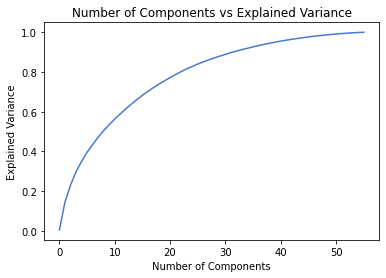

In [29]:
# We want to find the number of components that explains most of the variance
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Number of Components vs Explained Variance')

Looks like just 60 components is enough to explain 100% of the variance in the training set features. This means we have a lot of dependent features (i.e. some features are just linear combinations of other features).

In [30]:
# Lets go ahead and reduce dimensionality to 60

svd = TruncatedSVD(60)
train_featurse_decomposed = svd.fit_transform(train_features)
test_featurse_decomposed = svd.transform(test_features)

In [31]:
run_log_reg(train_featurse_decomposed, test_featurse_decomposed, y_train, y_test, alpha = 1e-1)

F1: 0.588 | Pr: 0.458 | Re: 1.000 | AUC: 0.441 | Accuracy: 0.417 



SGDClassifier(alpha=0.1, loss='log', n_jobs=-1)

The performance is not as good as the feature selection techniques. Why ?

The main job of decomposition techniques, like TruncatedSVD, is to explain the variance in the dataset with fewer number of components. While doing this, it never considers the importance each feature had in predicting the target ('neurotic' or 'not-neurotic'). However, in the feature selection techniques, the feature importance or model weights is used each time a feature is removed or added. RFE and SFS in particular select features to optimize for model performance.

## Stacking Classifier with Feature Selection

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


batch_size = 128
epochs = 40

simple_nn = Sequential()
simple_nn.add(Dense(150, activation='relu', input_shape=(109,)))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(100, activation='relu'))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(1, activation='sigmoid'))

simple_nn.summary()

simple_nn.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('Joel\\saved_models\\neuro_stacking_w_feature_selection', monitor = 'val_accuracy', verbose = 1, save_best_only=True)
history = simple_nn.fit(train_features_selected.todense(), y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [checkpoint],
                    validation_data=(test_features_selected.todense(), y_test))

simple_nn = load_model('Joel\\saved_models\\neuro_stacking_w_feature_selection')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               16500     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 31,701
Trainable params: 31,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - ET

In [14]:
y_pred_prob = simple_nn.predict(test_features_selected.todense())
print_model_metrics(y_test, y_pred_prob)

1/1 [==============================] - 0s 81ms/step
F1: 0.737 | Pr: 0.889 | Re: 0.727 | AUC: 0.804 | Accuracy: 0.792 



In [15]:
def run_voting_clf(model_weights):
    #result_list, model_weights = data
    
    y_pred_prob = 0

    for model_name, model in model_dict.items():
        y_pred_prob += (model.predict_proba(test_features_selected)[:,1] * model_weights[model_name])

    #y_pred_prob += (simple_nn.get_preds(ds_type = DatasetType.Valid)[0].numpy()[:,0] * model_weights['simple_nn'])
    y_pred_prob += (simple_nn.predict(test_features_selected.todense()).ravel() * model_weights['simple_nn'])
    y_pred_prob /= sum(model_weights.values())
    f1 = print_model_metrics(y_test, y_pred_prob, return_metrics = True, verbose = 0)[0]
    return {'loss' : -f1, 'status' : STATUS_OK}

In [23]:
# Define all models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss = 'log', alpha = 0.01, penalty = 'l2', l1_ratio = 0.25) # LR Best Parameters : {'alpha': 0.01, 'l1_ratio': 0.25, 'penalty': 'l2'}
#svm = SVC(C = 0.1, kernel = 'poly', probability = True, degree=2) # SVM Best Parameters : {'C': 0.1, 'degree': 2, 'kernel': 'poly'}
nb = MultinomialNB(alpha = 100, class_prior = [0.5, 0.5]) # NB Best Parameters : {'alpha': 100}
knn = KNeighborsClassifier(n_neighbors = 15, weights = 'distance', n_jobs = -1) # KNN Best Parameters : {'n_neighbors': 15, 'weights': 'distance'}
rf = RandomForestClassifier(n_estimators = 250, min_samples_split = 15, max_depth = 3,  n_jobs = -1) # RF Best Parameters : {'max_depth': 3, 'min_samples_split': 15, 'n_estimators': 250}
xgb = XGBClassifier(n_estimators = 10, learning_rate = 0.1, max_depth = 3, reg_alpha= 0, n_jobs = -1) # XGB Best Parameters : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 0}


model_dict = dict(zip(['LR', 'NB', 'KNN', 'RF', 'XGB'], [lr, nb, knn, rf, xgb]))

for model_name, model in model_dict.items():
    print('Training {}'.format(model_name))
    model.fit(train_features_selected, y_train)

model_weights = {'KNN': 0.9681272809371848,
 'LR': 0.9435173381705553,
 'NB': 0.7997972722426544,
 'RF': 0.6630696788421228,
 'XGB': 0.08470367240347731,
 'simple_nn': 0.5210940797989047}
y_pred_prob = 0

for model_name, model in model_dict.items():
    y_pred_prob += (model.predict_proba(test_features_selected)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features_selected.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())

print_model_metrics(y_test, y_pred_prob)

Training LR
Training NB
Training KNN
Training RF
Training XGB
1/1 [==============================] - 0s 20ms/step
F1: 0.833 | Pr: 0.786 | Re: 1.000 | AUC: 0.937 | Accuracy: 0.833 



In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

trials = Trials()
model_weights = fmin(run_voting_clf,
    space= {
        'LR' : hp.uniform('LR', 0, 1),
       # 'SVM' : hp.uniform('SVM', 0, 1),
        'NB' : hp.uniform('NB', 0, 1),
        'KNN' : hp.uniform('KNN', 0, 1),
        'RF' : hp.uniform('RF', 0, 1),
        'XGB' : hp.uniform('XGB', 0, 1),
        'simple_nn' : hp.uniform('simple_nn', 0, 1),


    },
    algo=tpe.suggest,
    max_evals=100,
    trials = trials)

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms

In [22]:
model_weights

{'KNN': 0.9681272809371848,
 'LR': 0.9435173381705553,
 'NB': 0.7997972722426544,
 'RF': 0.6630696788421228,
 'XGB': 0.08470367240347731,
 'simple_nn': 0.5210940797989047}

1/1 [==============================] - 0s 20ms/step
F1: 0.833 | Pr: 0.786 | Re: 1.000 | AUC: 0.937 | Accuracy: 0.833 



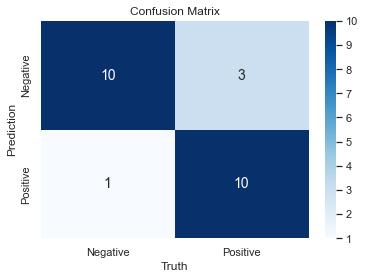

In [24]:
y_pred_prob = 0

for model_name, model in model_dict.items():
    y_pred_prob += (model.predict_proba(test_features_selected)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features_selected.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())

print_model_metrics(y_test, y_pred_prob, confusion = True)

In [39]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob, pos_label = 1)
    
#Find the threshold value that gives the best F1 Score
best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

# Calulcate predictions based on the threshold value
y_test_pred = np.where(y_pred_prob > best_threshold, 1, 0)
misclassified_idx = y_test != y_test_pred
high_confidence_indices = np.argsort(y_pred_prob[misclassified_idx])[-10:]

for idx in high_confidence_indices:
    print('Title : {}'.format(test[misclassified_idx].text.values[idx]))
    print('Label : {}'.format(test[misclassified_idx].neuro_bin.values[idx]))
    print('Predicted Probability : {}'.format(y_pred_prob[misclassified_idx][idx]))
    print('-' * 10)



Title : Du stehst hier rum... da hat dich meine Freundin entdeckt. Weiß nicht mehr genau. Wasserhahn repariert. Glücklich. Computerspiele. Sauber machen. Whiskey und Rumpsteak
Label : 1
Predicted Probability : 0.4587472319072523
----------
Title : Josephs. Mit meinem Bruder am Wochenende. Abgabe eines Uni Dokuments. Super, ich fühle mich glücklich, erholt und voller guter Stimmung. Das Thema Nachhaltigkeit und wie wir unseren Lebensraum und die Natur schützen können. Ständiges aufräumen, planen und Listen.. Ein perfektes Date mit meinem Schwarm stell ich mir so vor, dass wir zunächst etwas unternehmen, z.B. ein Ausflug in der Stadt mit Essen gehen oder ein netter Spaziergang in der Natur. Eine ruhige Umgebung für Unterhaltungen ist hierfür optimal. Am Abend wäre je nach dem wie man sich versteht, ein Film ein netter Abschluss.
Label : 1
Predicted Probability : 0.48979229989119705
----------
Title : Ich habe da so einen Link bekommen.. Das will ich lieber nicht machen.. Ich habe schon e

In [19]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from scipy import sparse


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


def adjusted_f1(y_true, y_prob):
    f1 = print_model_metrics(y_true, y_prob, verbose = 0, return_metrics = True)[0]
    return f1

score = make_scorer(adjusted_f1, greater_is_better = True, needs_proba = True)



# Since we want to use a predefined Test/Val set, we'll use PredefinedSplit and pass it as the CV parameter
# We need to merge both the datasets and label 0 for test and -1 for the train set

X = sparse.vstack((train_features_selected, test_features_selected))
test_fold = [-1 for _ in range(train_features_selected.shape[0])] + [0 for _ in range(test_features_selected.shape[0])]
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv = ps, n_jobs = -1, scoring = score, verbose = 0, refit = False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)

# Run log reg n times and average the metrics
def fit_n_times(model, x_train, y_train, x_test, y_test, n_iters = 10):
    metrics = np.zeros(5)
    for _ in range(n_iters):
        model.fit(x_train, y_train)
        y_test_prob = model.predict_proba(x_test)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, verbose = False, return_metrics = True)
    metrics /=10
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))
    

from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss = 'log')
lr_params = {'alpha' : [10**(-x) for x in range(7)],
             'penalty' : ['l1', 'l2', 'elasticnet'],
             'l1_ratio' : [0.15, 0.25, 0.5, 0.75]}

best_params, best_f1 = run_grid_search(lr, lr_params, X, y)

print('LR Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))


from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(class_prior = [0.5, 0.5])
nb_params = {'alpha' : [10**(x) for x in range(6)]}


best_params, best_f1 = run_grid_search(nb, nb_params, X, y)

print('NB Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs = -1)

knn_params = { 'n_neighbors' : [3, 5, 7, 9, 15, 31], 
               'weights' : ['uniform', 'distance']
}

best_params, best_f1 = run_grid_search(knn, knn_params, X, y)
print('KNN Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs = -1)

rf_params = { 'n_estimators' : [10, 100, 250, 500, 1000], 
               'max_depth' : [None, 3, 7, 15],
               'min_samples_split' : [2, 5, 15]
}

best_params, best_f1 = run_grid_search(rf, rf_params, X, y)

print('RF Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs = 1)

xgb_params = { 'n_estimators' : [10, 100, 200, 500], 
               'max_depth' : [1, 2, 3, 7],
               'learning_rate' : [0.1, 0.2, 0.01, 0.3],
               'reg_alpha' : [0, 0.1, 0.2]
}

best_params, best_f1 = run_grid_search(xgb, xgb_params, X, y)

print('XGB Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

LR Best Parameters : {'alpha': 0.01, 'l1_ratio': 0.25, 'penalty': 'l2'}
Best F1 : 0.9523809523809523
NB Best Parameters : {'alpha': 100}
Best F1 : 0.8571428571428572
KNN Best Parameters : {'n_neighbors': 15, 'weights': 'distance'}
Best F1 : 0.6923076923076923
RF Best Parameters : {'max_depth': 3, 'min_samples_split': 15, 'n_estimators': 250}
Best F1 : 0.8
XGB Best Parameters : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 0}
Best F1 : 0.7200000000000001
